# 시계열 분석(정석)

## #01. 작업준비

### 패키지 참조

In [1]:
from pandas import read_excel
from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#  정상성을 만족하는지 여부 판단
from statsmodels.tsa.stattools import adfuller

# 
from statsmodels.tsa.arima_model import ARIMA

import seaborn as sb
import sys

### 데이터 가져오기

In [2]:
df = read_excel("https://data.hossam.kr/E06/kings.xlsx")
df

,age
0,60
1,43
2,67
3,50
4,56
5,42
6,50
7,65
8,68
9,43


### 그래프 초기화

In [3]:
plt.rcParams['font.family'] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['axes.unicode_minus'] = False

step1 : 차분 적용 여부 결정
- 평균이동(단순평균이동.지수평균이동) 

step2 : ACF, PACF 검정 
- 상관관계를 도표를 통해 확인해봄으로서 정상성 만족여부를 파악
- ACF, PACF Plot으로 적용할 모델을 결정

step3 : ADF test 
- 차분을 몇 번 수행하는 것이 좋을지 결정
- 통계적으로 귀무가설의 기각여부를 확인하는 방법

## #02. ACF, PACF 검정

정상 시계열 데이터의 경우, ACF는 상대적으로 빠르게 0(상관관계 0)을 접근한다. 

비정상 시계열 데이터의 경우, ACF는 천천히 감소하며 종종 큰 양의 값을 갖는다.

|구분| $AR(p)$ 모델 적합 | $MA(q)$ 모델 적합|
|---|------------|------------|
|ACF plot | 천천히 감소 | 첫 값으로부터 $q$개 뒤에 끊긴다 |
|PACF plot| 첫 값으로부터 $p$개 뒤에 끊긴다 | 천천히 감소

천천히 감소 = 안정적이다

### ACF Plot

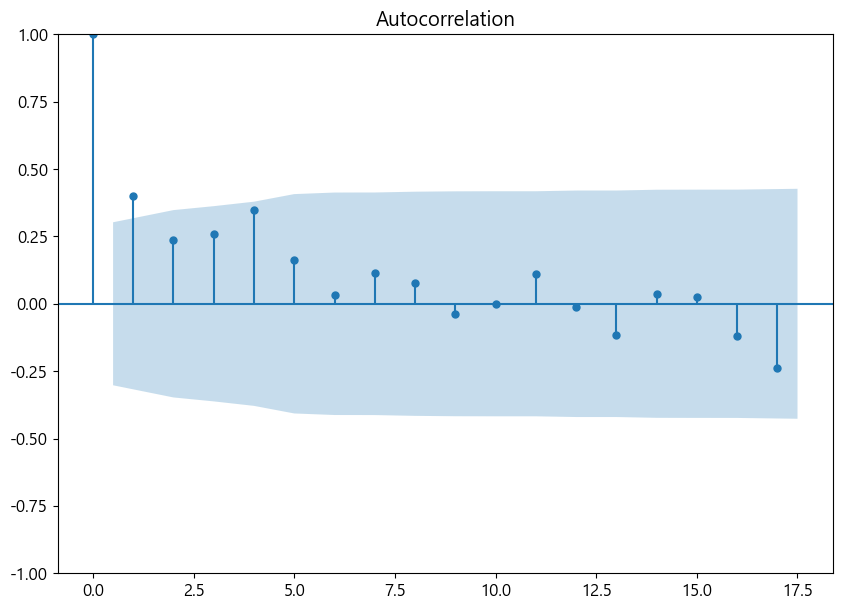

In [4]:
plot_acf(df)
plt.show()
plt.close()

### PACF Plot

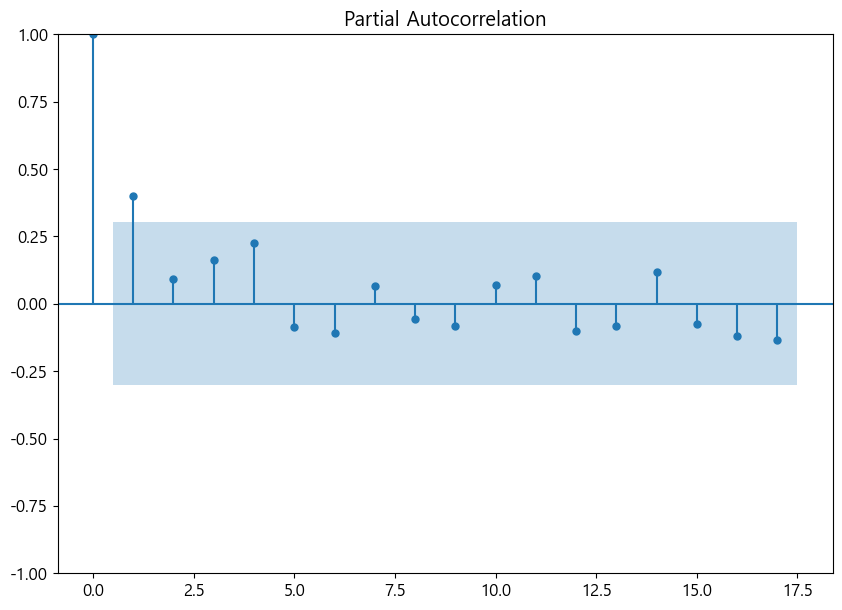

In [5]:
plot_pacf(df)
plt.show()
plt.close()

### 결과 판정

|구분|ACF plot|PACF plot|
|---|----|---|
|감소|상대적으로 급격|상대적으로 완만|
|파란박스 진입 지점|$p$ = 1| $q$ = 1|

이 결과를 고려하여 완만함을 보이는 PACF 플롯을 채택

MA(1) 모델로 결정

### 원본 데이터에 대한 ADF 테스트

ACF, PACF Plot으로 적용할 모델을 결정한다면 차분을 몇 번 수행하는 것이 좋을지 결정해야 한다.

|모델|의미|
|---|---|
| $AR(n)$ | $ARIMA(p,d,q)$ 중에서 $p=n, q=0$이라는 의미|
| $MA(n)$ | $ARIMA(p,d,q)$ 중에서 $p=0, q=n$이라는 의미|

ADF 테스트의 결과로 차분의 횟수가 결정되면 이 값이 $d$를 의미함.

#### ADF 테스트의 가설

ADF Test : 시계열이 안정적인지 여부를 확인하는데 이용되는 방법 

|가설|내용|
|--|--|
|귀무가설|데이터가 정상성과 다르다(=비정상성임을 의미)|
|대립가성|데이터가 정상성이다|

In [7]:
ar = adfuller(df)

print('ADF Statistic : %f' % ar[0])
print('p-value : %f' % ar[1])
print('num of lags : %f' % ar[2])
print('num of observations : %f' % ar[3])
print('Critical Values: ')
for key, value in ar[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic : -4.090230
p-value : 0.001005
num of lags : 0.000000
num of observations : 41.000000
Critical Values: 
	1%: -3.601
	5%: -2.935
	10%: -2.606


p-value가 0.05보다 작으므로 귀무가설을 기각하고 대립가설 채택. 즉, 예제 데이터는 정상성 데이터

만약 귀무가설이 채택되어 정상성이 아니라고 판단될 경우 차분을 1회 수행하고 다시 ADF 검정을 수행

대립가설이 채택될때까지 이 과정을 반복함

반복횟수가 $d$값이 됨

> 이 예제에서는 1번의 차분은 수행해야 한다고 가정함

## #03. 차분수행

In [8]:
diff1 = df.diff().dropna()
diff1.head()

,age
1,-17.0
2,24.0
3,-17.0
4,6.0
5,-14.0


### 차분 결과로 ADF 테스트 다시 수행

In [9]:
ar = adfuller(diff1)

print('ADF Statistic : %f' % ar[0])
print('p-value : %f' % ar[1])
print('num of lags : %f' % ar[2])
print('num of observations : %f' % ar[3])
print('Critical Values: ')
for key, value in ar[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic : -6.300508
p-value : 0.000000
num of lags : 2.000000
num of observations : 38.000000
Critical Values: 
	1%: -3.616
	5%: -2.941
	10%: -2.609


## #04. ARIMA 분석 수행